## Modeling Using LR


In [1]:
import pandas as pd
import numpy as np
import math,os,sys

import seaborn as sns
import matplotlib.pyplot as plt

from functools import partial
sys.path.insert(0,r"C:\Users\M1049231\Dev\Equifax")
from utils import efx_utils

sns.set_style(style= 'darkgrid')
sns.set_context("notebook")
%matplotlib inline
%load_ext lab_black

In [2]:
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, precision_recall_curve, auc, accuracy_score
from sklearn.feature_selection import f_classif
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.stats import chi2_contingency

In [3]:
import pickle
res = efx_utils._load_all()
FINAL_FEAT_V2 = res["FINAL_FEAT_V2"]
X = res["X"][FINAL_FEAT_V2]
y = res['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)


files being loaded are :  ['FINAL_FEAT.pkl', 'FINAL_FEAT_V2.pkl', 'X.pkl', 'y.pkl']


In [4]:
X_test.columns

Index(['BAL_AMT_MEAN_16987.17<50952.96', 'AGE_34.0<41.0', 'AGE_>41.0',
       'LIMIT_BAL_<=50000.0', 'BAL_AMT_MEAN_753.46<16987.17',
       'LIMIT_BAL_140000.0<240000.0', 'AGE_28.0<34.0', 'LIMIT_BAL_>240000.0',
       'BAL_AMT_MEAN_>50952.96', 'LIMIT_BAL_50000.0<140000.0',
       'BAL_AMT_MEAN_<=753.46', 'AGE_<=28.0', 'TOT_DEFAULT_0',
       'TOT_DEFAULT_0<2', 'TOT_DEFAULT_>2', 'EDUCATION:5', 'MARRIAGE:1',
       'EDUCATION:2', 'SEX:2', 'MARRIAGE:2', 'EDUCATION:1', 'EDUCATION:4',
       'EDUCATION:3', 'SEX:1', 'MARRIAGE:3', 'EDUCATION:6'],
      dtype='object')

In [5]:
# define modeling pipeline
model = LogisticRegression(max_iter=1000, class_weight = 'balanced')

pipeline = Pipeline(steps=[('model', model)])

# define cross-validation criteria. RepeatedStratifiedKFold automatially takes care of the class imbalance while splitting
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

# fit and evaluate the logistic regression pipeline with cross-validation as defined in cv
scores = cross_val_score(pipeline, X_train, y_train, scoring = 'roc_auc', cv = cv)
AUROC = np.mean(scores)
GINI = AUROC * 2 - 1

# print the mean AUROC score and Gini
print('Mean AUROC: %.4f' % (AUROC))
print('Gini: %.4f' % (GINI))

Mean AUROC: 0.7559
Gini: 0.5119


In [6]:
pipeline.fit(X_train,y_train)

Pipeline(steps=[('model',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

In [7]:
y_pred = pipeline['model'].predict(X_test)
accuracy_score(y_test, y_pred)
print(f"The accuracy of the model is {round(accuracy_score(y_test,y_pred),3)*100} %")

The accuracy of the model is 73.2 %


In [8]:
feature_name = X_train.columns.values
# Create a summary table of our logistic regression model
summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)
# Create a new column in the dataframe, called 'Coefficients', with row values the transposed coefficients from the 'LogisticRegression' model
summary_table['Coefficients'] = np.transpose(pipeline['model'].coef_)
# Increase the index of every row of the dataframe with 1 to store our model intercept in 1st row
summary_table.index = summary_table.index + 1
# Assign our model intercept to this new row
summary_table.loc[0] = ['Intercept', pipeline['model'].intercept_[0]]
# Sort the dataframe by index
summary_table.sort_index(inplace = True)
# summary_table

In [9]:
summary_table["coff_mag"] = abs(summary_table.Coefficients)
summary_table.sort_values('coff_mag', ascending= False, inplace= True)

<AxesSubplot:xlabel='Feature name', ylabel='coff_mag'>

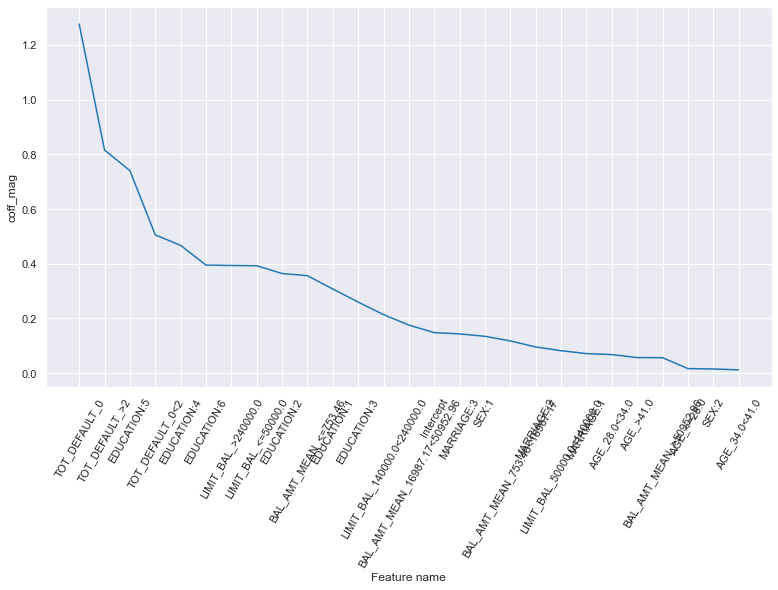

In [10]:
fig,ax = plt.subplots(figsize=(13, 7))
plt.xticks(rotation=60)
sns.lineplot(x = 'Feature name' , y = 'coff_mag', data= summary_table, ax = ax, )

In [11]:
# make preditions on our test set
y_hat_test = pipeline.predict(X_test)
# get the predicted probabilities
y_hat_test_proba = pipeline.predict_proba(X_test)
# select the probabilities of only the positive class (class 1 - default) 
y_hat_test_proba = y_hat_test_proba[:][: , 1]

# we will now create a new DF with actual classes and the predicted probabilities
# create a temp y_test DF to reset its index to allow proper concaternation with y_hat_test_proba
y_test_temp = pd.DataFrame(y_test.copy())
y_test_temp.reset_index(drop = True, inplace = True)
y_test_proba = pd.concat([y_test_temp, pd.DataFrame(y_hat_test_proba)], axis = 1)
# check the shape to make sure the number of rows is same as that in y_test
# y_test_proba.shape

# Rename the columns
y_test_proba.columns = ['y_test_class_actual', 'y_hat_test_proba']
# Makes the index of one dataframe equal to the index of another dataframe.
y_test_proba.index = X_test.index

In [12]:
# assign a threshold value to differentiate good with bad
tr = 0.5
# crate a new column for the predicted class based on predicted probabilities and threshold
# We will determine this optimat threshold later in this project
y_test_proba['y_test_class_predicted'] = np.where(y_test_proba['y_hat_test_proba'] > tr, 1, 0)
# create the confusion matrix
confusion_matrix(y_test_proba['y_test_class_actual'], y_test_proba['y_test_class_predicted'], normalize = 'all')

array([[0.597     , 0.18183333],
       [0.0865    , 0.13466667]])

In [18]:
y_test_proba.head()

,y_test_class_actual,y_hat_test_proba,y_test_class_predicted
6907,0,0.520273,1
24575,0,0.368235,0
26766,0,0.371684,0
2156,1,0.216534,0
3179,0,0.318233,0


In [23]:
"""

ROC curve is the plot of sensitivity (TPR) to 1- specificity (FPR)

+ve Recall aka TPR = TP / (TP + FN)
-ve Recall aka specificity = TN / (TN + FP)
1- specificity aka FPR = TP / (TN + FP)

"""
pass

Text(0.5, 1.0, 'ROC curve')

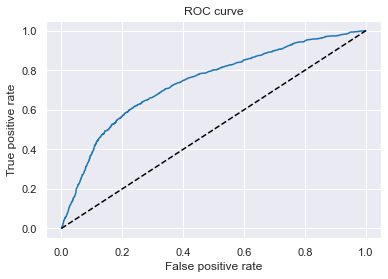

In [14]:

# get the values required to plot a ROC curve
fpr, tpr, thresholds = roc_curve(y_test_proba['y_test_class_actual'], y_test_proba['y_hat_test_proba'])
# plot the ROC curve
plt.plot(fpr, tpr)
# plot a secondary diagonal line, with dashed line style and black color to represent a no-skill classifier
plt.plot(fpr, fpr, linestyle = '--', color = 'k')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')

In [15]:
# Calculate the Area Under the Receiver Operating Characteristic Curve (AUROC) on our test set
AUROC = roc_auc_score(y_test_proba['y_test_class_actual'], y_test_proba['y_hat_test_proba'])
AUROC


0.7371313761767927

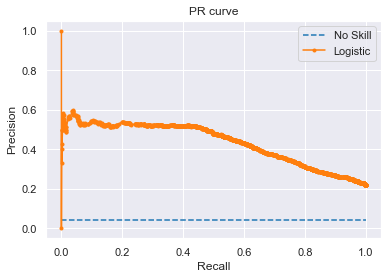

In [16]:

# draw a PR curve
# calculate the no skill line as the proportion of the positive class
no_skill = len(y_test[y_test == 1]) / len(y)
# plot the no skill precision-recall curve
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')

# calculate inputs for the PR curve
precision, recall, thresholds = precision_recall_curve(y_test_proba['y_test_class_actual'], y_test_proba['y_hat_test_proba'])
# plot PR curve
plt.plot(recall, precision, marker='.', label='Logistic')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.title('PR curve');

In [17]:
# calculate PR AUC
auc_pr = auc(recall, precision)
auc_pr

0.43590633516162436